In [711]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn 
from tqdm import tqdm

### Task 1

The data set I will be using contains the number of passengers (in thousands)
traveling internationally per month. This is a time series data set because it
has a variable (number of passengers) that varies throughout time (monthly).

The data set comes from here: https://www.kaggle.com/datasets/andreazzini/international-airline-passengers

Time series data is a certain kind of sequence data. Moreover, the order of the
data is very important because past values serve as an indicator for future
values. In machine learning, sequence models take this kind of behavior into
account, unlike feed-forward models, where predictions are entirely independent
of one another. Specifically, an RNN, LSTM, or GRU are all sequence models that
can be used with time series data. To use these models in this homework, I will
use the PyTorch framework, which already has these models implemented. 

In [712]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


df = pd.read_csv("airline_passengers.csv")
df

Using cpu device


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


The table below describes the data. There is only one feature, the number of
passengers (in thousands). The number of data points is 144, which is somewhat
low but sufficient enough for time series data. The data set is somewhat
balanced, with a standard deviation of 119.96 and a mean of 280.29.

Also, looking at the plot below, we can see that the time series is not
stationary. It will be interesting to see how the neural models can predict
this compared to traditional time series methods.

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


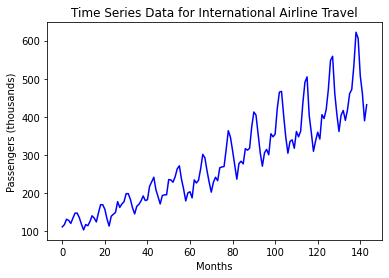

In [713]:
plt.title("Time Series Data for International Airline Travel")
plt.xlabel("Months")
plt.ylabel("Passengers (thousands)")
plt.plot(df["Passengers"], color='b')
df.describe()

Below, I craft the only feature used to train the RNN, LSTM, and GRU. Using the
passenger data, I chose a lag length of 6  (the sequence length is 6). With
this length, I have a matrix containing sequences of length six which are the
direct past values used to predict a future value: 

$x = P_{t-6}, P_{t-5}, P_{t-4}, P_{t-3}, P_{t-2}, P_{t-1}$ \
$y = P_t$

Additionally, I split the data into a train, validation, and test set. The
train set contains 75 percent of the data; the validation set contains 12.5
percent and the test set contains 12.5 percent. Lastly, I set the epoch count
to 350, which is used for all the models. 

In [714]:
def norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

data = norm(np.asarray(df["Passengers"]))
lags = 6
a = data[:data.shape[0]-6].reshape( 1, data.shape[0]-lags).T
b = data[1:data.shape[0]-5].reshape( 1, data.shape[0]-lags).T
c = data[2:data.shape[0]-4].reshape( 1, data.shape[0]-lags).T
d = data[3:data.shape[0]-3].reshape( 1, data.shape[0]-lags).T
e = data[4:data.shape[0]-2].reshape( 1, data.shape[0]-lags).T
f = data[5:data.shape[0]-1].reshape( 1, data.shape[0]-lags).T
X = np.hstack((a, b, c, d, e, f))
# X = data[:data.shape[0]-lags]
Y = data[lags:]
assert(X.shape[0] == Y.shape[0])
N = X.shape[0]


train_size = int(N * (3/4))
val_size = int(N/8)

X_train = torch.Tensor(X[:train_size].reshape(train_size, lags, 1))
X_val = torch.Tensor(X[train_size: train_size + val_size].reshape(val_size, lags, 1))
X_test = torch.Tensor(X[train_size + val_size:].reshape(N - (train_size + val_size), lags, 1))

Y_train = torch.Tensor(Y[:train_size].reshape(train_size, 1))
Y_val = torch.Tensor(Y[train_size: train_size + val_size].reshape(val_size, 1))
Y_test = torch.Tensor(Y[train_size + val_size:].reshape(N - (train_size + val_size), 1))


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)
epochs = 275

torch.Size([103, 6, 1])
torch.Size([17, 6, 1])
torch.Size([18, 6, 1])
torch.Size([103, 1])
torch.Size([17, 1])
torch.Size([18, 1])


##### Part 1

In [715]:
class RNN(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(RNN, self).__init__()
        self.hidden_d = hidden_d
        self.layer_d = layer_d
        self.rnn = nn.RNN(input_d, hidden_d, layer_d, batch_first=True, nonlinearity='tanh')
        self.linear = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.linear(out[:, -1, :]) 
        return out
    

rnn_model = RNN(1, 100, 1, 1)
loss_fn = nn.MSELoss()
learning_rate = 0.05
optimizer = torch.optim.Adadelta(rnn_model.parameters(), lr=learning_rate)

mse = []
val_mse = []
for epoch in tqdm(range(epochs)):
    
    val_output = rnn_model(X_val)
    val_loss = loss_fn(val_output, Y_val)
    val_mse.append(val_loss.item())
    optimizer.zero_grad()
    outputs = rnn_model(X_train)
    loss = loss_fn(outputs, Y_train)
    mse.append(loss.item())
    loss.backward()
    optimizer.step()

100%|██████████| 275/275 [00:00<00:00, 471.83it/s]


min error: 0.006412651389837265
min val error: 0.023277029395103455
test error: 0.042212408035993576


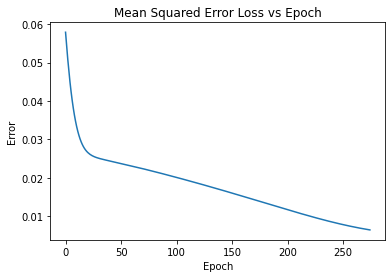

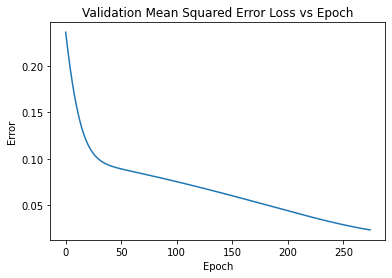

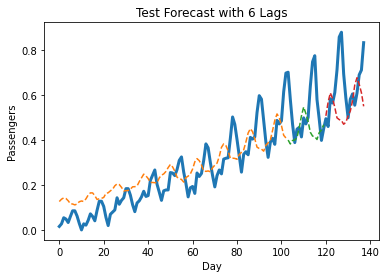

In [716]:
test_output = rnn_model(X_test)
test_error = loss_fn(test_output, Y_test).item()
print(f"min error: {min(mse)}")
print(f"min val error: {min(val_mse)}")
print(f"test error: {test_error}")


plt.figure(1)
plt.title("Mean Squared Error Loss vs Epoch")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.plot(mse)

plt.figure(2)
plt.title("Validation Mean Squared Error Loss vs Epoch")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.plot(val_mse)

plt.figure(3)
plt.title(f"Test Forecast with {lags} Lags")
plt.ylabel("Passengers")
plt.xlabel("Day")
plt.plot(data[:len(data)-lags], linewidth=3)
plt.plot(range(0, train_size), rnn_model(X_train).flatten().detach(), linestyle='dashed')
plt.plot(range(train_size, train_size+val_size), rnn_model(X_val).flatten().detach(), linestyle='dashed')
plt.plot(range(train_size+val_size, N), rnn_model(X_test).flatten().detach(), linestyle='dashed')

##### Part 2

In [717]:
class LSTM(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTM, self).__init__()
        self.hidden_d = hidden_d
        self.layer_d = layer_d
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True)
        self.linear = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        out, hidden = self.lstm(x)
        out = self.linear(out[:, -1, :]) 
        return out
    

lstm_model = LSTM(1, 100, 1, 1)
loss_fn = nn.MSELoss()
learning_rate = 0.5
optimizer = torch.optim.Adadelta(lstm_model.parameters(), lr=learning_rate)

mse = []
val_mse = []

for epoch in tqdm(range(epochs)):    
    val_output = lstm_model(X_val)
    val_loss = loss_fn(val_output, Y_val)
    val_mse.append(val_loss.item())
    optimizer.zero_grad()
    outputs = lstm_model(X_train)
    loss = loss_fn(outputs, Y_train)
    mse.append(loss.item())
    loss.backward()
    optimizer.step()

100%|██████████| 275/275 [00:01<00:00, 143.01it/s]


min error: 0.004461888689547777
min val error: 0.012283505871891975
test error: 0.02332509309053421


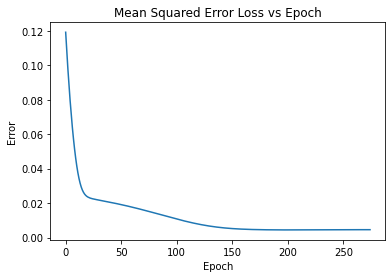

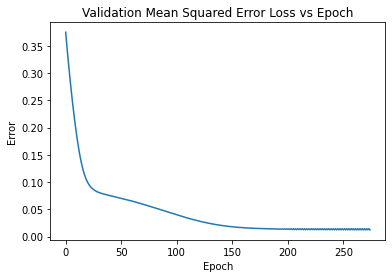

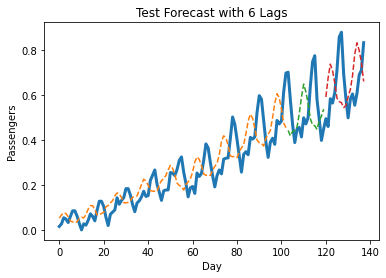

In [718]:
test_output = lstm_model(X_test)
test_error = loss_fn(test_output, Y_test).item()
print(f"min error: {min(mse)}")
print(f"min val error: {min(val_mse)}")
print(f"test error: {test_error}")


plt.figure(1)
plt.title("Mean Squared Error Loss vs Epoch")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.plot(mse)

plt.figure(2)
plt.title("Validation Mean Squared Error Loss vs Epoch")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.plot(val_mse)

plt.figure(3)
plt.title(f"Test Forecast with {lags} Lags")
plt.ylabel("Passengers")
plt.xlabel("Day")
plt.plot(data[:len(data)-lags], linewidth=3)
plt.plot(range(0, train_size), lstm_model(X_train).flatten().detach(), linestyle='dashed')
plt.plot(range(train_size, train_size+val_size), lstm_model(X_val).flatten().detach(), linestyle='dashed')
plt.plot(range(train_size+val_size, N), test_output.flatten().detach(), linestyle='dashed')
plt.show()

In [719]:
class GRU(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(GRU, self).__init__()
        self.hidden_d = hidden_d
        self.layer_d = layer_d
        self.gru = nn.GRU(input_d, hidden_d, layer_d, batch_first=True)
        self.linear = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        out, hidden = self.gru(x)
        out = self.linear(out[:, -1, :]) 
        return out
    

gru_model = GRU(1, 100, 1, 1)
loss_fn = nn.MSELoss()
learning_rate = 0.1
optimizer = torch.optim.Adadelta(gru_model.parameters(), lr=learning_rate)

mse = []
val_mse = []

for epoch in tqdm(range(epochs)):    
    val_output = gru_model(X_val)
    val_loss = loss_fn(val_output, Y_val)
    val_mse.append(val_loss.item())
    optimizer.zero_grad()
    outputs = gru_model(X_train)
    loss = loss_fn(outputs, Y_train)
    mse.append(loss.item())
    loss.backward()
    optimizer.step()

100%|██████████| 275/275 [00:01<00:00, 180.33it/s]


min error: 0.005848540458828211
min val error: 0.020908404141664505
test error: 0.03671523183584213


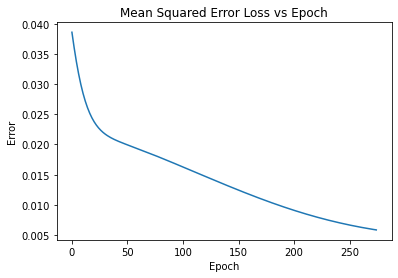

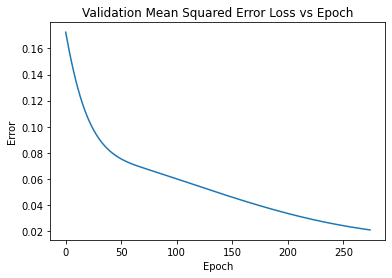

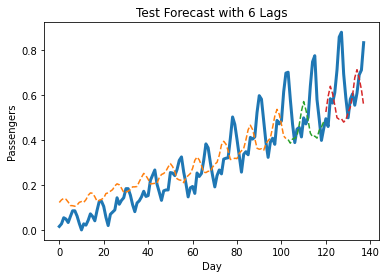

In [720]:
test_output = gru_model(X_test)
test_error = loss_fn(test_output, Y_test).item()
print(f"min error: {min(mse)}")
print(f"min val error: {min(val_mse)}")
print(f"test error: {test_error}")


plt.figure(1)
plt.title("Mean Squared Error Loss vs Epoch")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.plot(mse)

plt.figure(2)
plt.title("Validation Mean Squared Error Loss vs Epoch")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.plot(val_mse)

plt.figure(3)
plt.title(f"Test Forecast with {lags} Lags")
plt.ylabel("Passengers")
plt.xlabel("Day")
plt.plot(data[:len(data)-lags], linewidth=3)
plt.plot(range(0, train_size), gru_model(X_train).flatten().detach(), linestyle='dashed')
plt.plot(range(train_size, train_size+val_size), gru_model(X_val).flatten().detach(), linestyle='dashed')
plt.plot(range(train_size+val_size, N), test_output.flatten().detach(), linestyle='dashed')
plt.show()

##### Part 3

### Task 2




[1] Kagie, Martijn & Wezel, M.C. & Groenen, Patrick. (2009). An Empirical Comparison of Dissimilarity Measures for Recommender Systems. Erasmus Research Institute of Management (ERIM), ERIM is the joint research institute of the Rotterdam School of Management, Erasmus University and the Erasmus School of Economics (ESE) at Erasmus Uni, Research Paper. 